## Installing Required Dependencies

In [ ]:
!pip install --user openai

In [ ]:
!pip install --user python-dotenv

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report

import os
from os.path import join
import dotenv
import time

from torch.utils.data import DataLoader, Dataset

import openai

import pickle

## Loading OpenAI API Key

In [2]:
dotenv.load_dotenv('../env/.env')

True

In [3]:
openai.organization = os.getenv("OPENAI_ORG_ID")
openai.api_key = os.getenv("OPENAI_API_KEY")

## Prompt Engineering and Getting API Result

In [5]:
def ask_gpt(q1, q2, max_retries=2):
    retries = 0
    response = None

    while retries < max_retries:
        try:
            response = openai.ChatCompletion.create(
                model="gpt-3.5-turbo",
                messages=[
                    {
                    "role": "system",
                    "content": "You are tasked to look at question pairs from the platform Quora and decide if they are duplicates or not."
                    },
                    {
                    "role": "user",
                    "content": "The following are two questions from Quora, the social question-and-answer website." +
                                f"\n\nQuestion 1:\n\"{q1}\"\n\nQuestion 2:\n\"{q2}\"\n\nThink through both the questions above, " +
                                 "understand the semantics of these two questions and decide if they are semantically similar to each other or not, " +
                                "i.e. decide if they are duplicates. You do not need to be very strict;  it is fine for Question 1 and Question 2 to contain " +
                                "slight differences in semantics and be considered as not duplicates.\n\nIf they are duplicates, your response should be a \"1\"." +
                                "If they are not duplicates, your response should be a \"0\". \n\nIt suffices to just respond with a single value \"1\" or \"0\"."
                    }
                ],
                temperature=1,
                max_tokens=1,
                top_p=1,
                frequency_penalty=0,
                presence_penalty=0
            )
            response = int(response['choices'][0]["message"]["content"])
            break
        except Exception as e:
            print(e)
            retries += 1
            if retries >= max_retries:
                response = None
            else:
                delay = 2 ** retries # exp backoff
                print(f"Retrying in {delay} seconds")
                time.sleep(delay)
    return response

## Importing Dataset

In [6]:
DATA_DIR = join('..', 'data', 'glue')

In [7]:
def remove_nulls(df):
    print(f"Initial dataframe has {len(df)} rows.")
    null_rows = df[df.isnull().values.any(1)]
    print(f"Dataframe has {len(null_rows)} null rows.")
    df = df.dropna(how='any')
    print(f"Dataframe has {len(df)} rows after removing null values.")
    return df

In [8]:
test_df = pd.read_csv(join(DATA_DIR, 'dev.tsv'), sep='\t')
test_df = remove_nulls(test_df)
test_df.head()

Initial dataframe has 40430 rows.
Dataframe has 0 null rows.
Dataframe has 40430 rows after removing null values.


,id,qid1,qid2,question1,question2,is_duplicate
0,201359,303345,303346,Why are African-Americans so beautiful?,Why are hispanics so beautiful?,0
1,263843,69383,380476,I want to pursue PhD in Computer Science about...,I handle social media for a non-profit. Should...,0
2,172974,266948,175089,Is there a reason why we should travel alone?,What are some reasons to travel alone?,1
3,15329,29298,29299,Why are people so obsessed with having a girlf...,How can a single male have a child?,0
4,209794,314169,314170,What are some good baby girl names starting wi...,What are some good baby girl names starting wi...,0


In [9]:
test_df.shape

(40430, 6)

In [10]:
X_test = test_df.iloc[:,:-1]
y_test = test_df.iloc[:,-1]

In [11]:
X_test.head()

,id,qid1,qid2,question1,question2
0,201359,303345,303346,Why are African-Americans so beautiful?,Why are hispanics so beautiful?
1,263843,69383,380476,I want to pursue PhD in Computer Science about...,I handle social media for a non-profit. Should...
2,172974,266948,175089,Is there a reason why we should travel alone?,What are some reasons to travel alone?
3,15329,29298,29299,Why are people so obsessed with having a girlf...,How can a single male have a child?
4,209794,314169,314170,What are some good baby girl names starting wi...,What are some good baby girl names starting wi...


## Dataset and DataLoader

In [12]:
class DuplicateQuestionDataset(Dataset):
    
    def __init__(self, questions, labels):
        self.questions = questions
        self.labels = labels
        
    def __len__(self):
        return len(self.questions)
    
    def __getitem__(self, idx):
        q1, q2 = self.questions[['question1', 'question2']].iloc[idx]
        label = self.labels.iloc[idx]
        
        return q1, q2, label        

In [13]:
batch_size = 1

test_dataset = DuplicateQuestionDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Asking GPT

Philosophy: Realistically, this is how most AI startups work, i.e. there have been jokes about how most AI startups today are just API calls to OpenAI's GPT models.

In [ ]:
gpt_responses = []
true_labels = []

for q1, q2, label in tqdm(test_loader):
    response = ask_gpt(q1, q2, max_retries=4)
    
    gpt_responses.append(response)
    true_labels.append(label) 
    
    time.sleep(1.5)

gpt_responses = np.array(gpt_responses)
true_labels = np.array(true_labels)

In [32]:
with open('gpt_responses.pkl', 'wb') as file:
    pickle.dump(gpt_responses, file)

In [ ]:
with open('gpt_responses.pkl', 'rb') as file:
    loaded_gpt_responses = pickle.load(file)

## Evaluation (Benchmark)

In [21]:
num_responses = len(gpt_responses)
num_responses

7396

In [33]:
true_labels = [tl.item() for tl in true_labels]

In [34]:
accuracy = accuracy_score(true_labels[:num_responses], gpt_responses) * 100
print(f"GPT-3.5 Accuracy: {accuracy: .2f}%")

GPT-3.5 Accuracy:  70.93%


In [38]:
def print_classification_metrics():
    true, predicted = true_labels, gpt_responses

    print(classification_report(true, predicted))

    fpr, tpr, _ = roc_curve(true, predicted)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    print(f"AUC-ROC: {roc_auc:.2f}")

              precision    recall  f1-score   support

           0       0.71      0.91      0.79      4568
           1       0.72      0.39      0.51      2828

    accuracy                           0.71      7396
   macro avg       0.71      0.65      0.65      7396
weighted avg       0.71      0.71      0.68      7396



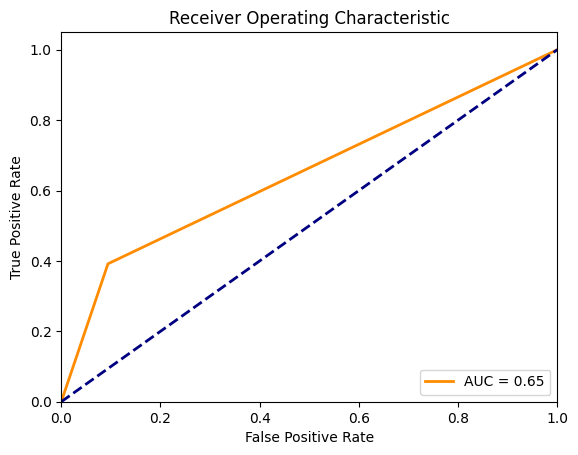

AUC-ROC: 0.65


In [39]:
print_classification_metrics()